# Method 2: Haplotype-block Laplace perturbation (CEU control / CASE_POP case)

This notebook implements the haplotype-block DP mechanism with:
- Control = CEU (public reference)
- Case = CASE_POP (private)
- Membership inference: CASE_POP case_train (members) vs CASE_POP case_test (non-members)


In [48]:

import json
import math
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt


# Robust PROJECT_ROOT detection


def find_project_root(start: Optional[Path] = None) -> Path:
    start = Path.cwd() if start is None else Path(start)
    cur = start.resolve()
    if (cur / "requirements.txt").exists() or (cur / ".git").exists():
        return cur
    for parent in cur.parents:
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            return parent
    return cur

PROJECT_ROOT = find_project_root()
print("PROJECT_ROOT =", PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw" / "hapmap"
PROC_DIR = DATA_DIR / "processed" / "hapmap"
DERIVED_DIR = DATA_DIR / "derived" / "method2"

REGIONS_DIR = PROC_DIR / "regions"
BLOCKS_DIR = PROC_DIR / "blocks"
HAPS_DIR = PROC_DIR / "haplotypes"
COHORTS_DIR = PROC_DIR / "cohorts"
PHASE_INFO_DIR = PROC_DIR / "phasing"

RESULTS_DIR = PROJECT_ROOT / "results"
FIG_DIR = RESULTS_DIR / "figures" / "method2"
TABLE_DIR = RESULTS_DIR / "tables" / "method2"

for d in [DERIVED_DIR, FIG_DIR, TABLE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CASE_POP_JSON = COHORTS_DIR / "hapmap_case_pop.json"
if not CASE_POP_JSON.exists():
    raise FileNotFoundError(f"Missing case_pop config: {CASE_POP_JSON}")

case_info = json.loads(CASE_POP_JSON.read_text())
CASE_POP = case_info["case_pop"]
PHASE_INFO_JSON = PHASE_INFO_DIR / f"{CASE_POP.lower()}_phased_paths.json"


SPLIT_SEED = 0
SEEDS = list(range(30))
EPS_LIST = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

PVALUE_CUTOFF = 1e-3
P_CLIP = 1e-6
MIN_SNPS_PER_BLOCK = 3
FORCE_REDOWNLOAD = False

print("CASE_POP =", CASE_POP)
print("SPLIT_SEED =", SPLIT_SEED)
print("SEEDS =", SEEDS)
print("EPS_LIST =", EPS_LIST)
print("PVALUE_CUTOFF =", PVALUE_CUTOFF)
print("Chance baseline LR power ~ 0.05")


PROJECT_ROOT = /Users/erkmenerken/Desktop/proje430
CASE_POP = MKK
SPLIT_SEED = 0
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
EPS_LIST = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
PVALUE_CUTOFF = 0.001
Chance baseline LR power ~ 0.05


In [49]:
import urllib.request



def pick_existing(primary: Path, fallback: Path, label: str) -> Path:
    if primary.exists():
        return primary
    if fallback.exists():
        print(f"[WARN] Using fallback for {label}: {fallback.name}")
        return fallback
    raise FileNotFoundError(f"Missing {label}: {primary} (or fallback {fallback})")


def download_file(url: str, dst: Path, overwrite: bool = False, chunk_size: int = 1024 * 1024) -> None:
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and not overwrite:
        size_bytes = dst.stat().st_size
        if size_bytes > 0:
            print(f"  Already exists, skipping: {dst.name} ({size_bytes/1e6:.2f} MB)")
            return
        print(f"  Existing file is empty, re-downloading: {dst.name}")

    tmp = dst.with_suffix(dst.suffix + ".part")
    print(f"  Downloading: {url}")
    print(f"  Saving to  : {dst}")

    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as resp:
        with open(tmp, "wb") as f:
            while True:
                chunk = resp.read(chunk_size)
                if not chunk:
                    break
                f.write(chunk)

    os.replace(tmp, dst)
    print(f"  Done: {dst.name} ({dst.stat().st_size/1e6:.2f} MB)")


def ensure_snps_by_individuals(G: np.ndarray) -> np.ndarray:
    if G.shape[0] < G.shape[1]:
        return G.T
    return G


def normalize_col(colname: str) -> str:
    s = str(colname).strip()
    if "." in s:
        s = s.split(".", 1)[0]
    return s


def normalize_id(x: str) -> str:
    s = normalize_col(x)
    if s.lower().endswith("_a") or s.lower().endswith("_b"):
        s = s[:-2]
    return s


In [50]:



REGION_CEU_CHR2 = PROJECT_ROOT / case_info["regions"]["chr2_5Mb"]["ceu_region"]
REGION_CEU_CHR10 = PROJECT_ROOT / case_info["regions"]["chr10_1Mb"]["ceu_region"]
REGION_CASE_CHR2 = PROJECT_ROOT / case_info["regions"]["chr2_5Mb"]["case_region"]
REGION_CASE_CHR10 = PROJECT_ROOT / case_info["regions"]["chr10_1Mb"]["case_region"]

COHORT_CEU_CHR2 = PROJECT_ROOT / case_info["regions"]["chr2_5Mb"]["ceu_control_npz"]
COHORT_CEU_CHR10 = PROJECT_ROOT / case_info["regions"]["chr10_1Mb"]["ceu_control_npz"]

HAPS_CEU_CHR2 = HAPS_DIR / f"CEU_chr2_5Mb.common_with_{CASE_POP}.control_haplotypes.phased_compatible.json"
HAPS_CEU_CHR10 = HAPS_DIR / f"CEU_chr10_1Mb.common_with_{CASE_POP}.control_haplotypes.phased_compatible.json"

BLOCKS_CHR2 = BLOCKS_DIR / f"CEU_chr2_5Mb.common_with_{CASE_POP}.blocks.json"
BLOCKS_CHR10 = BLOCKS_DIR / f"CEU_chr10_1Mb.common_with_{CASE_POP}.blocks.json"

if not PHASE_INFO_JSON.exists():
    raise FileNotFoundError(f"Missing phased paths JSON: {PHASE_INFO_JSON}")

for p in [REGION_CEU_CHR2, REGION_CEU_CHR10, REGION_CASE_CHR2, REGION_CASE_CHR10,
          HAPS_CEU_CHR2, HAPS_CEU_CHR10, BLOCKS_CHR2, BLOCKS_CHR10,
          COHORT_CEU_CHR2, COHORT_CEU_CHR10, PHASE_INFO_JSON]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}. Run preprocessing notebook.")

print("Assets found.")
print("  chr2 CEU region:", REGION_CEU_CHR2.relative_to(PROJECT_ROOT))
print("  chr10 CEU region:", REGION_CEU_CHR10.relative_to(PROJECT_ROOT))
print("  chr2 CASE region:", REGION_CASE_CHR2.relative_to(PROJECT_ROOT))
print("  chr10 CASE region:", REGION_CASE_CHR10.relative_to(PROJECT_ROOT))
print("  chr2 haps:", HAPS_CEU_CHR2.relative_to(PROJECT_ROOT))
print("  chr10 haps:", HAPS_CEU_CHR10.relative_to(PROJECT_ROOT))


Assets found.
  chr2 CEU region: data/processed/hapmap/regions/CEU_chr2_5Mb.common_with_MKK.npz
  chr10 CEU region: data/processed/hapmap/regions/CEU_chr10_1Mb.common_with_MKK.npz
  chr2 CASE region: data/processed/hapmap/regions/MKK_chr2_5Mb.common_with_CEU.npz
  chr10 CASE region: data/processed/hapmap/regions/MKK_chr10_1Mb.common_with_CEU.npz
  chr2 haps: data/processed/hapmap/haplotypes/CEU_chr2_5Mb.common_with_MKK.control_haplotypes.phased_compatible.json
  chr10 haps: data/processed/hapmap/haplotypes/CEU_chr10_1Mb.common_with_MKK.control_haplotypes.phased_compatible.json


In [51]:

info = json.loads(PHASE_INFO_JSON.read_text())

PHASE_CEU_CHR2 = Path(info["CEU"]["chr2"]["path"])
PHASE_CEU_CHR10 = Path(info["CEU"]["chr10"]["path"])
PHASE_CASE_CHR2 = Path(info["case"]["chr2"]["path"])
PHASE_CASE_CHR10 = Path(info["case"]["chr10"]["path"])

for p in [PHASE_CEU_CHR2, PHASE_CEU_CHR10, PHASE_CASE_CHR2, PHASE_CASE_CHR10]:
    if not p.exists():
        raise FileNotFoundError(f"Missing resolved phased file: {p}")

print("Resolved phased files:")
print(" CEU chr2:", PHASE_CEU_CHR2.relative_to(PROJECT_ROOT))
print(" CEU chr10:", PHASE_CEU_CHR10.relative_to(PROJECT_ROOT))
print(f" {CASE_POP} chr2:", PHASE_CASE_CHR2.relative_to(PROJECT_ROOT))
print(f" {CASE_POP} chr10:", PHASE_CASE_CHR10.relative_to(PROJECT_ROOT))


Resolved phased files:
 CEU chr2: data/raw/hapmap/phasing/HapMap3_r2/CEU/TRIOS/hapmap3_r2_b36_fwd.consensus.qc.poly.chr2_ceu.phased.gz
 CEU chr10: data/raw/hapmap/phasing/HapMap3_r2/CEU/TRIOS/hapmap3_r2_b36_fwd.consensus.qc.poly.chr10_ceu.phased.gz
 MKK chr2: data/raw/hapmap/phasing/HapMap3_r2/MKK/UNRELATED/hapmap3_r2_b36_fwd.consensus.qc.poly.chr2_mkk.unr.phased.gz
 MKK chr10: data/raw/hapmap/phasing/HapMap3_r2/MKK/UNRELATED/hapmap3_r2_b36_fwd.consensus.qc.poly.chr10_mkk.unr.phased.gz


In [52]:

# Load CEU region data + control MAF (minor allele reference)


def load_region_npz(path: Path) -> Dict[str, np.ndarray]:
    z = np.load(path, allow_pickle=True)
    return {k: z[k] for k in z.files}


def load_indices_npz(path: Path) -> List[int]:
    z = np.load(path, allow_pickle=True)
    return list(z["indices"].astype(int))

ceu_chr2 = load_region_npz(REGION_CEU_CHR2)
ceu_chr10 = load_region_npz(REGION_CEU_CHR10)

idx_control_chr2 = load_indices_npz(COHORT_CEU_CHR2)
idx_control_chr10 = load_indices_npz(COHORT_CEU_CHR10)

print("Loaded CEU regions:")
print("  chr2 G:", ceu_chr2["G"].shape)
print("  chr10 G:", ceu_chr10["G"].shape)
print(f"CEU control counts: chr2={len(idx_control_chr2)}, chr10={len(idx_control_chr10)}")

# Load CASE_POP regions (sample IDs for cohort intersection)
case_chr2_region = load_region_npz(REGION_CASE_CHR2)
case_chr10_region = load_region_npz(REGION_CASE_CHR10)

case_ids_chr2 = [normalize_id(x) for x in case_chr2_region["sample_ids"]]
case_ids_chr10 = [normalize_id(x) for x in case_chr10_region["sample_ids"]]

print(f"Loaded {CASE_POP} regions:")
print("  chr2 G:", case_chr2_region["G"].shape)
print("  chr10 G:", case_chr10_region["G"].shape)
print("  chr2 samples:", len(case_ids_chr2))
print("  chr10 samples:", len(case_ids_chr10))
print(f"{CASE_POP} ids chr2 first 5:", case_ids_chr2[:5])
print(f"{CASE_POP} ids chr10 first 5:", case_ids_chr10[:5])

G_chr2 = ensure_snps_by_individuals(ceu_chr2["G"])
G_chr10 = ensure_snps_by_individuals(ceu_chr10["G"])

if len(idx_control_chr2) == 0 or len(idx_control_chr10) == 0:
    raise RuntimeError("No CEU control indices found. Check cohort NPZ.")


def compute_allele_a_freq(G_snps_x_ind: np.ndarray, cols: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    sub = G_snps_x_ind[:, cols]
    called = sub != -1
    called_n = called.sum(axis=1).astype(np.int32)
    sub_nonmiss = np.where(called, sub, 0)
    count_a = sub_nonmiss.sum(axis=1).astype(np.float64)
    denom = 2.0 * np.maximum(called_n, 1)
    freq_a = count_a / denom
    return count_a, freq_a

count_a_chr2, freq_a_chr2 = compute_allele_a_freq(G_chr2, idx_control_chr2)
count_a_chr10, freq_a_chr10 = compute_allele_a_freq(G_chr10, idx_control_chr10)

# Minor allele reference from CEU region npz
minor_chr2 = np.array(ceu_chr2.get("minor_alleles", ceu_chr2.get("counted_alleles")), dtype=object)
major_chr2 = np.array(ceu_chr2.get("major_alleles", ceu_chr2.get("other_alleles")), dtype=object)
minor_chr10 = np.array(ceu_chr10.get("minor_alleles", ceu_chr10.get("counted_alleles")), dtype=object)
major_chr10 = np.array(ceu_chr10.get("major_alleles", ceu_chr10.get("other_alleles")), dtype=object)

allele_a_chr2 = np.array(ceu_chr2.get("counted_alleles", ceu_chr2.get("minor_alleles")), dtype=object)
allele_a_chr10 = np.array(ceu_chr10.get("counted_alleles", ceu_chr10.get("minor_alleles")), dtype=object)

p_minor_ctrl_chr2 = np.where(allele_a_chr2 == minor_chr2, freq_a_chr2, 1.0 - freq_a_chr2)
p_minor_ctrl_chr10 = np.where(allele_a_chr10 == minor_chr10, freq_a_chr10, 1.0 - freq_a_chr10)

print("CEU control minor allele freq ranges:")
print(" chr2:", float(np.nanmin(p_minor_ctrl_chr2)), "..", float(np.nanmax(p_minor_ctrl_chr2)))
print(" chr10:", float(np.nanmin(p_minor_ctrl_chr10)), "..", float(np.nanmax(p_minor_ctrl_chr10)))


Loaded CEU regions:
  chr2 G: (165, 300)
  chr10 G: (165, 588)
CEU control counts: chr2=165, chr10=165
Loaded MKK regions:
  chr2 G: (171, 300)
  chr10 G: (171, 588)
  chr2 samples: 171
  chr10 samples: 171
MKK ids chr2 first 5: ['NA21741', 'NA21740', 'NA21733', 'NA21784', 'NA21768']
MKK ids chr10 first 5: ['NA21741', 'NA21740', 'NA21733', 'NA21784', 'NA21768']
CEU control minor allele freq ranges:
 chr2: 0.0030303030303030303 .. 0.996969696969697
 chr10: 0.0030303030303030303 .. 0.996969696969697


In [53]:

# Load CEU phased data + build phased-compatible SNP list (per region)


def load_phased_df(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep=r"\s+", engine="python", compression="gzip", dtype=str)
    if "rsID" not in df.columns:
        raise ValueError("Unexpected phased file columns; expected 'rsID'.")
    return df


def build_phased_compatible(region: Dict[str, np.ndarray], phased_df: pd.DataFrame, label: str):
    region_snp_ids = np.array([str(x) for x in region["snp_ids"]], dtype=object)
    region_positions = np.array(region["positions"], dtype=int)

    phased_rsids = set(phased_df["rsID"].astype(str).tolist())
    keep_mask = np.array([rs in phased_rsids for rs in region_snp_ids], dtype=bool)

    snp_ids_sub = region_snp_ids[keep_mask]
    positions_sub = region_positions[keep_mask]
    region_idx_sub = np.where(keep_mask)[0]

    print(f"[{label}] phased-compatible SNPs: {len(snp_ids_sub)} / {len(region_snp_ids)}")
    if len(snp_ids_sub) == 0:
        raise RuntimeError(f"No SNPs from {label} found in phased file.")

    return {
        "snp_ids": snp_ids_sub,
        "positions": positions_sub,
        "region_idx": region_idx_sub,
    }

ceu_phase_chr2 = load_phased_df(PHASE_CEU_CHR2)
ceu_phase_chr10 = load_phased_df(PHASE_CEU_CHR10)

pc_chr2 = build_phased_compatible(ceu_chr2, ceu_phase_chr2, "CEU chr2")
pc_chr10 = build_phased_compatible(ceu_chr10, ceu_phase_chr10, "CEU chr10")

# Map CEU minor allele and control MAF to phased-compatible SNP list
minor_pc_chr2 = minor_chr2[pc_chr2["region_idx"]]
major_pc_chr2 = major_chr2[pc_chr2["region_idx"]]
minor_pc_chr10 = minor_chr10[pc_chr10["region_idx"]]
major_pc_chr10 = major_chr10[pc_chr10["region_idx"]]

p_minor_ctrl_pc_chr2 = p_minor_ctrl_chr2[pc_chr2["region_idx"]]
p_minor_ctrl_pc_chr10 = p_minor_ctrl_chr10[pc_chr10["region_idx"]]

print("Phased-compatible SNP counts:")
print(" chr2:", len(pc_chr2["snp_ids"]))
print(" chr10:", len(pc_chr10["snp_ids"]))


[CEU chr2] phased-compatible SNPs: 274 / 300
[CEU chr10] phased-compatible SNPs: 541 / 588
Phased-compatible SNP counts:
 chr2: 274
 chr10: 541


In [54]:

# Load CEU control haplotypes (topK + OTHER per block)


haps_chr2 = json.loads(HAPS_CEU_CHR2.read_text())
haps_chr10 = json.loads(HAPS_CEU_CHR10.read_text())

blocks_chr2 = haps_chr2["blocks"]
blocks_chr10 = haps_chr10["blocks"]

print("Haplotype blocks (phased-compatible):")
print(" chr2 blocks:", len(blocks_chr2))
print(" chr10 blocks:", len(blocks_chr10))



def filter_blocks_to_pc(blocks, pc_len, label):
    max_end = max(b["end_snp_index"] for b in blocks)
    if max_end < pc_len:
        return blocks
    print(f"[WARN] {label}: block indices exceed phased-compatible SNP count (max_end={max_end}, pc_len={pc_len}).")
    filtered = [b for b in blocks if b["end_snp_index"] < pc_len]
    dropped = len(blocks) - len(filtered)
    print(f"[WARN] {label}: dropping {dropped} blocks outside pc range.")
    if not filtered:
        raise RuntimeError(f"{label}: no blocks remain after filtering. Rebuild haplotype files.")
    return filtered

blocks_chr2 = filter_blocks_to_pc(blocks_chr2, len(pc_chr2["snp_ids"]), "chr2")
blocks_chr10 = filter_blocks_to_pc(blocks_chr10, len(pc_chr10["snp_ids"]), "chr10")


Haplotype blocks (phased-compatible):
 chr2 blocks: 5
 chr10 blocks: 10


In [55]:


# Load CASE_POP phased data and align to CEU phased-compatible SNP list


def phased_individuals_from_columns(df: pd.DataFrame):
    a_cols = {}
    b_cols = {}

    def add_col(target, indiv, col):
        existing = target.get(indiv)
        if existing is None:
            target[indiv] = col
            return
        if "." in existing and "." not in col:
            target[indiv] = col

    for col in df.columns:
        base = normalize_col(col)
        low = base.lower()
        if low.endswith("_a"):
            indiv = base[:-2]
            add_col(a_cols, indiv, col)
        elif low.endswith("_b"):
            indiv = base[:-2]
            add_col(b_cols, indiv, col)

    individuals = sorted(set(a_cols.keys()).intersection(b_cols.keys()))

    print("Phased haplotype columns:")
    print("  A columns:", len(a_cols))
    print("  B columns:", len(b_cols))
    print("  Paired individuals:", len(individuals))

    return individuals, a_cols, b_cols


def build_case_phased_pc(phase_path: Path, pc_snp_ids: np.ndarray, label: str):
    df = load_phased_df(phase_path)
    individuals_raw, a_cols_map, b_cols_map = phased_individuals_from_columns(df)
    individuals = [normalize_id(i) for i in individuals_raw]

    A_cols = [a_cols_map[i] for i in individuals_raw]
    B_cols = [b_cols_map[i] for i in individuals_raw]

    rs_list = df["rsID"].astype(str).tolist()
    rs_to_idx = {rs: i for i, rs in enumerate(rs_list)}

    row_for_pc = np.array([rs_to_idx.get(rs, -1) for rs in pc_snp_ids], dtype=int)
    matched = int(np.sum(row_for_pc >= 0))
    print(f"[{label}] matched SNPs: {matched} / {len(pc_snp_ids)}")

    alleles_A_full = df[A_cols].to_numpy(dtype=object)
    alleles_B_full = df[B_cols].to_numpy(dtype=object)

    n_pc = len(pc_snp_ids)
    n_ind = len(individuals)
    A_pc = np.empty((n_pc, n_ind), dtype=object)
    B_pc = np.empty((n_pc, n_ind), dtype=object)
    A_pc[:] = ""
    B_pc[:] = ""

    for i, row_idx in enumerate(row_for_pc):
        if row_idx >= 0:
            A_pc[i] = alleles_A_full[row_idx]
            B_pc[i] = alleles_B_full[row_idx]

    print(f"[{label}] unique individuals: {len(individuals)}")

    return {
        "individuals": individuals,
        "individuals_raw": individuals_raw,
        "alleles_A_pc": A_pc,
        "alleles_B_pc": B_pc,
        "row_for_pc": row_for_pc,
    }

case_chr2 = build_case_phased_pc(PHASE_CASE_CHR2, pc_chr2["snp_ids"], f"{CASE_POP} chr2")
case_chr10 = build_case_phased_pc(PHASE_CASE_CHR10, pc_chr10["snp_ids"], f"{CASE_POP} chr10")

print(f"{CASE_POP} phased individuals:")
print(" chr2:", len(case_chr2["individuals"]))
print(" chr10:", len(case_chr10["individuals"]))
print(" chr2 first 5:", case_chr2["individuals"][:5])
print(" chr10 first 5:", case_chr10["individuals"][:5])


Phased haplotype columns:
  A columns: 87
  B columns: 87
  Paired individuals: 87
[MKK chr2] matched SNPs: 274 / 274
[MKK chr2] unique individuals: 87
Phased haplotype columns:
  A columns: 87
  B columns: 87
  Paired individuals: 87
[MKK chr10] matched SNPs: 541 / 541
[MKK chr10] unique individuals: 87
MKK phased individuals:
 chr2: 87
 chr10: 87
 chr2 first 5: ['NA21295', 'NA21297', 'NA21300', 'NA21311', 'NA21314']
 chr10 first 5: ['NA21295', 'NA21297', 'NA21300', 'NA21311', 'NA21314']


In [56]:

overlap_chr2 = sorted(set(case_ids_chr2).intersection(case_chr2["individuals"]))
overlap_chr10 = sorted(set(case_ids_chr10).intersection(case_chr10["individuals"]))

print(f"{CASE_POP} chr2 genotype ids:", len(case_ids_chr2))
print(f"{CASE_POP} chr2 phased ids:", len(case_chr2["individuals"]))
print(f"{CASE_POP} chr2 genotype ∩ phased:", len(overlap_chr2))
print(f"{CASE_POP} chr2 overlap first 5:", overlap_chr2[:5])

print(f"{CASE_POP} chr10 genotype ids:", len(case_ids_chr10))
print(f"{CASE_POP} chr10 phased ids:", len(case_chr10["individuals"]))
print(f"{CASE_POP} chr10 genotype ∩ phased:", len(overlap_chr10))
print(f"{CASE_POP} chr10 overlap first 5:", overlap_chr10[:5])

if len(overlap_chr2) < 10 or len(overlap_chr10) < 10:
    print("[WARN] Overlap sizes are small; privacy/utility estimates may be unstable.")


MKK chr2 genotype ids: 171
MKK chr2 phased ids: 87
MKK chr2 genotype ∩ phased: 87
MKK chr2 overlap first 5: ['NA21295', 'NA21297', 'NA21300', 'NA21311', 'NA21314']
MKK chr10 genotype ids: 171
MKK chr10 phased ids: 87
MKK chr10 genotype ∩ phased: 87
MKK chr10 overlap first 5: ['NA21295', 'NA21297', 'NA21300', 'NA21311', 'NA21314']


In [57]:

# CASE_POP case split (train vs test for membership inference)


def split_case(individuals: List[str], seed: int = 0, frac_train: float = 0.7):
    rng = np.random.default_rng(seed)
    shuffled = list(rng.permutation(individuals))
    n = len(shuffled)
    n_train = int(round(n * frac_train))

    if n >= 60:
        n_train = max(30, min(n - 30, n_train))
    elif n >= 40:
        n_train = max(20, min(n - 20, n_train))
    n_train = max(1, min(n - 1, n_train))

    train = shuffled[:n_train]
    test = shuffled[n_train:]
    return train, test

# Per-region split 
idx_map_chr2 = {sid: i for i, sid in enumerate(case_chr2["individuals"])}
idx_map_chr10 = {sid: i for i, sid in enumerate(case_chr10["individuals"])}

train_ids_chr2, test_ids_chr2 = split_case(overlap_chr2, seed=SPLIT_SEED, frac_train=0.7)
train_ids_chr10, test_ids_chr10 = split_case(overlap_chr10, seed=SPLIT_SEED, frac_train=0.7)

train_idx_chr2 = [idx_map_chr2[sid] for sid in train_ids_chr2 if sid in idx_map_chr2]
test_idx_chr2 = [idx_map_chr2[sid] for sid in test_ids_chr2 if sid in idx_map_chr2]
train_idx_chr10 = [idx_map_chr10[sid] for sid in train_ids_chr10 if sid in idx_map_chr10]
test_idx_chr10 = [idx_map_chr10[sid] for sid in test_ids_chr10 if sid in idx_map_chr10]

split_payload = {
    "case_pop": CASE_POP,
    "seed": SPLIT_SEED,
    "case_train": {
        "sample_ids_chr2": train_ids_chr2,
        "sample_ids_chr10": train_ids_chr10,
        "indices_in_case_phased_chr2": train_idx_chr2,
        "indices_in_case_phased_chr10": train_idx_chr10,
    },
    "case_test": {
        "sample_ids_chr2": test_ids_chr2,
        "sample_ids_chr10": test_ids_chr10,
        "indices_in_case_phased_chr2": test_idx_chr2,
        "indices_in_case_phased_chr10": test_idx_chr10,
    },
}

out_split = COHORTS_DIR / f"{CASE_POP.lower()}_case_test_split.json"
out_split.write_text(json.dumps(split_payload, indent=2))
print("Saved CASE_POP split:", out_split.relative_to(PROJECT_ROOT))
print(f"{CASE_POP} train/test sizes chr2:", len(train_idx_chr2), len(test_idx_chr2))
print(f"{CASE_POP} chr2 train ids first 5:", train_ids_chr2[:5])
print(f"{CASE_POP} chr2 test ids first 5:", test_ids_chr2[:5])
print(f"{CASE_POP} train/test sizes chr10:", len(train_idx_chr10), len(test_idx_chr10))
print(f"{CASE_POP} chr10 train ids first 5:", train_ids_chr10[:5])
print(f"{CASE_POP} chr10 test ids first 5:", test_ids_chr10[:5])

if len(train_idx_chr2) < 10 or len(test_idx_chr2) < 10:
    print("[WARN] chr2 train/test sizes are small; results may be unstable.")
if len(train_idx_chr10) < 10 or len(test_idx_chr10) < 10:
    print("[WARN] chr10 train/test sizes are small; results may be unstable.")


Saved CASE_POP split: data/processed/hapmap/cohorts/mkk_case_test_split.json
MKK train/test sizes chr2: 57 30
MKK chr2 train ids first 5: [np.str_('NA21371'), np.str_('NA21356'), np.str_('NA21353'), np.str_('NA21519'), np.str_('NA21318')]
MKK chr2 test ids first 5: [np.str_('NA21573'), np.str_('NA21826'), np.str_('NA21740'), np.str_('NA21776'), np.str_('NA21719')]
MKK train/test sizes chr10: 57 30
MKK chr10 train ids first 5: [np.str_('NA21371'), np.str_('NA21356'), np.str_('NA21353'), np.str_('NA21519'), np.str_('NA21318')]
MKK chr10 test ids first 5: [np.str_('NA21573'), np.str_('NA21826'), np.str_('NA21740'), np.str_('NA21776'), np.str_('NA21719')]


In [58]:

# Allele alignment sanity check


MISSING_ALLELES = {"", "N", "NA", "0", "NN"}

def valid_snp_mask(alleles_A_pc: np.ndarray, alleles_B_pc: np.ndarray, minor: np.ndarray, major: np.ndarray, label: str) -> np.ndarray:
    n_snps = alleles_A_pc.shape[0]
    valid = np.ones(n_snps, dtype=bool)
    for j in range(n_snps):
        allowed = {minor[j], major[j]}
        a = alleles_A_pc[j]
        b = alleles_B_pc[j]
        observed = set([x for x in np.concatenate([a, b]) if isinstance(x, str) and x not in MISSING_ALLELES])
        if not observed.issubset(allowed):
            valid[j] = False
    bad = int((~valid).sum())
    print(f"[{label}] SNPs failing allele check: {bad} / {n_snps}")
    return valid

valid_chr2 = valid_snp_mask(case_chr2["alleles_A_pc"], case_chr2["alleles_B_pc"], minor_pc_chr2, major_pc_chr2, "chr2")
valid_chr10 = valid_snp_mask(case_chr10["alleles_A_pc"], case_chr10["alleles_B_pc"], minor_pc_chr10, major_pc_chr10, "chr10")


[chr2] SNPs failing allele check: 0 / 274
[chr10] SNPs failing allele check: 0 / 541


In [59]:


def compute_genotype_dosage(alleles_A: np.ndarray, alleles_B: np.ndarray, minor: np.ndarray) -> np.ndarray:
    n_snps, n_ind = alleles_A.shape
    dosage = np.full((n_snps, n_ind), -1, dtype=np.int8)
    for j in range(n_snps):
        m = minor[j]
        a = alleles_A[j]
        b = alleles_B[j]
        ok = (a != "") & (b != "")
        dosage[j, ok] = ((a[ok] == m).astype(np.int8) + (b[ok] == m).astype(np.int8))
    return dosage


def compute_called_counts(alleles_A: np.ndarray, alleles_B: np.ndarray, indices: List[int]) -> np.ndarray:
    A = alleles_A[:, indices]
    B = alleles_B[:, indices]
    ok = (A != "") & (B != "")
    return ok.sum(axis=1).astype(np.int32)


def chisq_pvalues_case_vs_control(mac_case: np.ndarray, called_case: np.ndarray,
                                 mac_ctrl: np.ndarray, called_ctrl: np.ndarray) -> np.ndarray:
    n = mac_case.shape[0]
    pvals = np.ones(n, dtype=np.float64)

    for j in range(n):
        minor_case = mac_case[j]
        major_case = 2.0 * called_case[j] - minor_case
        minor_ctrl = mac_ctrl[j]
        major_ctrl = 2.0 * called_ctrl[j] - minor_ctrl

        if called_case[j] <= 0 or called_ctrl[j] <= 0:
            pvals[j] = 1.0
            continue
        if major_case < 0 or major_ctrl < 0:
            pvals[j] = 1.0
            continue

        table = np.array([[minor_case, major_case],
                          [minor_ctrl, major_ctrl]], dtype=np.float64)
        if np.any(table.sum(axis=1) <= 0) or np.any(table.sum(axis=0) <= 0):
            pvals[j] = 1.0
            continue

        try:
            _, p, _, _ = chi2_contingency(table, correction=False)
            pvals[j] = float(p)
        except Exception:
            pvals[j] = 1.0

    return pvals


def overlap_metrics(sig_true: np.ndarray, sig_noisy: np.ndarray) -> Dict[str, float]:
    a = sig_true.astype(bool)
    b = sig_noisy.astype(bool)
    tp = int(np.sum(a & b))
    fp = int(np.sum(~a & b))
    fn = int(np.sum(a & ~b))
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) else 0.0
    return {
        "true_sig": int(np.sum(a)),
        "noisy_sig": int(np.sum(b)),
        "tp": tp,
        "precision": float(precision),
        "recall": float(recall),
        "jaccard": float(jaccard),
    }


def genotype_log_prob_hwe(g: np.ndarray, p: np.ndarray) -> np.ndarray:
    p = np.clip(p, P_CLIP, 1.0 - P_CLIP)
    q = 1.0 - p
    logP0 = 2.0 * np.log(q)
    logP1 = np.log(2.0) + np.log(p) + np.log(q)
    logP2 = 2.0 * np.log(p)
    out = np.zeros_like(p, dtype=np.float64)
    out = np.where(g == 0, logP0, out)
    out = np.where(g == 1, logP1, out)
    out = np.where(g == 2, logP2, out)
    return out


def lr_scores(G_snps_x_ind: np.ndarray, cols: List[int], p_case: np.ndarray, p_ctrl: np.ndarray) -> np.ndarray:
    G = G_snps_x_ind[:, cols]
    n_ind = G.shape[1]
    scores = np.zeros(n_ind, dtype=np.float64)
    for i in range(n_ind):
        g = G[:, i]
        mask = g >= 0
        if not np.any(mask):
            continue
        log_case = genotype_log_prob_hwe(g[mask], p_case[mask])
        log_ctrl = genotype_log_prob_hwe(g[mask], p_ctrl[mask])
        scores[i] = float(np.sum(log_case - log_ctrl))
    return scores


def allele_count_from_dosage(G_snps_x_ind: np.ndarray, idx: List[int]) -> np.ndarray:
    Gsub = G_snps_x_ind[:, idx]
    mask = Gsub >= 0
    return np.where(mask, Gsub, 0).sum(axis=1).astype(np.float64)


In [60]:


def build_region_baseline(pc, case, minor_pc, major_pc, p_ctrl_pc, valid_mask, label: str):
    row_for_pc = case["row_for_pc"]
    matched_idx_pc = np.where((row_for_pc >= 0) & valid_mask)[0]

    if len(matched_idx_pc) == 0:
        raise RuntimeError(f"{label}: no CASE_POP SNPs matched to phased-compatible list after filtering.")

    A_pc = case["alleles_A_pc"][matched_idx_pc]
    B_pc = case["alleles_B_pc"][matched_idx_pc]
    minor_matched = minor_pc[matched_idx_pc]
    major_matched = major_pc[matched_idx_pc]
    p_ctrl_matched = p_ctrl_pc[matched_idx_pc]

    G_case = compute_genotype_dosage(A_pc, B_pc, minor_matched)
    pc_to_matched = {pc_idx: i for i, pc_idx in enumerate(matched_idx_pc)}

    return {
        "pc_snp_ids": pc["snp_ids"],
        "pc_positions": pc["positions"],
        "matched_idx_pc": matched_idx_pc,
        "pc_to_matched": pc_to_matched,
        "minor": minor_matched,
        "major": major_matched,
        "p_ctrl": p_ctrl_matched,
        "G_case": G_case,
        "alleles_A": A_pc,
        "alleles_B": B_pc,
    }

baseline_chr2 = build_region_baseline(pc_chr2, case_chr2, minor_pc_chr2, major_pc_chr2, p_minor_ctrl_pc_chr2, valid_chr2, "chr2")
baseline_chr10 = build_region_baseline(pc_chr10, case_chr10, minor_pc_chr10, major_pc_chr10, p_minor_ctrl_pc_chr10, valid_chr10, "chr10")

print("Baseline matched SNPs:")
print(" chr2:", len(baseline_chr2["matched_idx_pc"]))
print(" chr10:", len(baseline_chr10["matched_idx_pc"]))


Baseline matched SNPs:
 chr2: 274
 chr10: 541


In [61]:

# Method 2 DP mechanism + evaluation


def reduce_haplotypes(top_haps: List[str], keep_pos_in_block: List[int]) -> List[str]:
    if len(keep_pos_in_block) == 0:
        return []
    reduced = []
    seen = set()
    for h in top_haps:
        if len(h) <= max(keep_pos_in_block):
            continue
        r = "".join(h[i] for i in keep_pos_in_block)
        if r not in seen:
            seen.add(r)
            reduced.append(r)
    return reduced


def compute_block_noisy_freqs(alleles_A, alleles_B, case_idx, keep_pos, candidate_haps, eps_b, minor_block, p_ctrl_block, other_minor_frac_block, rng):
    counts = {h: 0 for h in candidate_haps}
    other = 0

    for ind in case_idx:
        hapA_parts = []
        okA = True
        for i in keep_pos:
            a = alleles_A[i, ind]
            if not isinstance(a, str) or len(a) != 1:
                okA = False
                break
            hapA_parts.append(a)
        hapA = "".join(hapA_parts) if okA else None

        hapB_parts = []
        okB = True
        for i in keep_pos:
            b = alleles_B[i, ind]
            if not isinstance(b, str) or len(b) != 1:
                okB = False
                break
            hapB_parts.append(b)
        hapB = "".join(hapB_parts) if okB else None

        if hapA is not None and hapA in counts:
            counts[hapA] += 1
        else:
            other += 1
        if hapB is not None and hapB in counts:
            counts[hapB] += 1
        else:
            other += 1

    hist = np.array([counts[h] for h in candidate_haps] + [other], dtype=np.float64)

    scale = 2.0 / eps_b
    noisy = hist + rng.laplace(loc=0.0, scale=scale, size=hist.shape[0])
    noisy = np.clip(noisy, 0.0, None)

    s = float(noisy.sum())
    if s <= 0:
        noisy_freq = np.ones_like(noisy) / len(noisy)
    else:
        noisy_freq = noisy / s

    p_minor = np.zeros(len(keep_pos), dtype=np.float64)

    for h_idx, h in enumerate(candidate_haps):
        for j in range(len(keep_pos)):
            p_minor[j] += noisy_freq[h_idx] * (1.0 if h[j] == minor_block[j] else 0.0)

    other_minor = other_minor_frac_block if other_minor_frac_block is not None else p_ctrl_block
    p_minor += noisy_freq[-1] * other_minor
    p_minor = np.clip(p_minor, 0.0, 1.0)

    return hist, noisy, noisy_freq, p_minor




def compute_block_hist_only(alleles_A, alleles_B, case_idx, keep_pos, candidate_haps):
    counts = {h: 0 for h in candidate_haps}
    other = 0

    for ind in case_idx:
        hapA_parts = []
        okA = True
        for i in keep_pos:
            a = alleles_A[i, ind]
            if not isinstance(a, str) or len(a) != 1:
                okA = False
                break
            hapA_parts.append(a)
        hapA = "".join(hapA_parts) if okA else None

        hapB_parts = []
        okB = True
        for i in keep_pos:
            b = alleles_B[i, ind]
            if not isinstance(b, str) or len(b) != 1:
                okB = False
                break
            hapB_parts.append(b)
        hapB = "".join(hapB_parts) if okB else None

        if hapA is not None and hapA in counts:
            counts[hapA] += 1
        else:
            other += 1
        if hapB is not None and hapB in counts:
            counts[hapB] += 1
        else:
            other += 1

    hist = np.array([counts[h] for h in candidate_haps] + [other], dtype=np.float64)
    return hist

def run_region(region_label, blocks, baseline, eps_list, case_idx, test_idx, n_ctrl):
    results = []
    per_seed_rows = []
    warn_blocks = set()

    # Build per-block metadata
    block_meta = []
    total_H = 0
    total_dropped = 0
    covered_pc = set()

    for b in blocks:
        start = b["start_snp_index"]
        end = b["end_snp_index"]

        keep_pos_pc = [i for i in range(start, end + 1) if i in baseline["pc_to_matched"]]
        keep_pos_matched = [baseline["pc_to_matched"][i] for i in keep_pos_pc]

        if len(keep_pos_matched) < MIN_SNPS_PER_BLOCK:
            total_dropped += 1
            continue

        keep_pos_in_block = [i - start for i in keep_pos_pc]
        top_haps = b["top_haplotypes"]
        reduced_haps = reduce_haplotypes(top_haps, keep_pos_in_block)
        H_b = len(reduced_haps) + 1

        for pc_idx in keep_pos_pc:
            covered_pc.add(pc_idx)

        total_H += H_b
        block_meta.append({
            "block": b,
            "keep_pos_matched": keep_pos_matched,
            "keep_pos_in_block": keep_pos_in_block,
            "reduced_haps": reduced_haps,
            "H_b": H_b,
        })

    print(f"[{region_label}] blocks kept: {len(block_meta)} / {len(blocks)} (dropped={total_dropped})")

    if total_H == 0:
        raise RuntimeError(f"[{region_label}] No valid blocks after filtering.")

  
    other_masses = []
    for bm in block_meta:
        hist = compute_block_hist_only(
            baseline["alleles_A"],
            baseline["alleles_B"],
            case_idx,
            bm["keep_pos_matched"],
            bm["reduced_haps"],
        )
        total = float(hist.sum())
        if total > 0:
            other_masses.append(float(hist[-1] / total))
    if other_masses:
        print(f"[{region_label}] mean OTHER mass (true): {float(np.mean(other_masses)):.4f}")

    covered_pc = sorted(covered_pc)
    covered_matched = np.array([baseline["pc_to_matched"][i] for i in covered_pc], dtype=int)

    G_case = baseline["G_case"][covered_matched]
    called_case = compute_called_counts(baseline["alleles_A"], baseline["alleles_B"], case_idx)[covered_matched]
    called_case = np.maximum(called_case, 1)
    mac_case_true = allele_count_from_dosage(G_case, case_idx)
    p_case_true = mac_case_true / (2.0 * called_case)

    p_ctrl = baseline["p_ctrl"][covered_matched]
    called_ctrl = np.full_like(called_case, n_ctrl)
    mac_ctrl = p_ctrl * (2.0 * called_ctrl)

    for eps in eps_list:
        printed_saved = False
        eps_b_list = [eps * bm["H_b"] / total_H for bm in block_meta]
        if abs(sum(eps_b_list) - eps) > 1e-6:
            print(f"[WARN] eps allocation mismatch: sum={sum(eps_b_list)} vs eps={eps}")

        
        eps_b_arr = np.array(eps_b_list, dtype=np.float64)
        scale_stats = 2.0 / eps_b_arr
        print(f"[{region_label}] eps={eps} eps_b(min/med/max)="
              f"{eps_b_arr.min():.4g}/{np.median(eps_b_arr):.4g}/{eps_b_arr.max():.4g} "
              f"scale(min/med/max)={scale_stats.min():.4g}/{np.median(scale_stats):.4g}/{scale_stats.max():.4g}")

        metrics_per_seed = []

        for seed in SEEDS:
            rng = np.random.default_rng(seed)
            noisy_maf_full = np.zeros_like(baseline["G_case"][:, 0], dtype=np.float64)
            block_outputs = []

            for bm, eps_b in zip(block_meta, eps_b_list):
                b = bm["block"]
                keep_pos_matched = bm["keep_pos_matched"]
                reduced_haps = bm["reduced_haps"]
                keep_pos_in_block = bm["keep_pos_in_block"]

                minor_block = baseline["minor"][keep_pos_matched]
                p_ctrl_block = baseline["p_ctrl"][keep_pos_matched]

                other_minor_full = b.get("other_minor_frac", None)
                other_minor_block = p_ctrl_block
                if other_minor_full is not None:
                    other_minor_full = np.array(other_minor_full, dtype=np.float64)
                    expected_len = (b["end_snp_index"] - b["start_snp_index"] + 1)
                    if len(other_minor_full) == expected_len:
                        other_minor_block = other_minor_full[keep_pos_in_block]
                    elif len(other_minor_full) == len(keep_pos_matched):
                        other_minor_block = other_minor_full
                    else:
                        warn_key = (region_label, b["block_id"], "other_minor_len")
                        if warn_key not in warn_blocks:
                            print(f"[WARN] {region_label} block {b['block_id']}: other_minor_frac length mismatch; using p_ctrl for OTHER.")
                            warn_blocks.add(warn_key)

                if len(other_minor_block) != len(keep_pos_matched):
                    warn_key = (region_label, b["block_id"], "other_minor_size")
                    if warn_key not in warn_blocks:
                        print(f"[WARN] {region_label} block {b['block_id']}: other_minor_block size mismatch; using p_ctrl for OTHER.")
                        warn_blocks.add(warn_key)
                    other_minor_block = p_ctrl_block

                hist, noisy_counts, noisy_freq, p_minor_block = compute_block_noisy_freqs(
                    baseline["alleles_A"],
                    baseline["alleles_B"],
                    case_idx,
                    keep_pos_matched,
                    reduced_haps,
                    eps_b,
                    minor_block,
                    p_ctrl_block,
                    other_minor_block,
                    rng,
                )

                for j, pos in enumerate(keep_pos_matched):
                    noisy_maf_full[pos] = p_minor_block[j]

                block_outputs.append({
                    "block_id": b["block_id"],
                    "start_snp_index": b["start_snp_index"],
                    "end_snp_index": b["end_snp_index"],
                    "num_snps_used": len(keep_pos_matched),
                    "H_b": bm["H_b"],
                    "eps_b": eps_b,
                    "true_hist": hist.tolist(),
                    "noisy_counts": noisy_counts.tolist(),
                    "noisy_freq": noisy_freq.tolist(),
                    "top_haplotypes_reduced": reduced_haps,
                })

            noisy_maf = noisy_maf_full[covered_matched]
            noisy_maf = np.clip(noisy_maf, 0.0, 1.0)

            
            mac_case_noisy = np.clip(np.rint(noisy_maf * (2.0 * called_case)), 0.0, 2.0 * called_case)
            p_true = chisq_pvalues_case_vs_control(mac_case_true, called_case, mac_ctrl, called_ctrl)
            p_noisy = chisq_pvalues_case_vs_control(mac_case_noisy, called_case, mac_ctrl, called_ctrl)
            sig_true = p_true <= PVALUE_CUTOFF
            sig_noisy = p_noisy <= PVALUE_CUTOFF
            ov = overlap_metrics(sig_true, sig_noisy)

            
            if seed == SEEDS[0]:
                print(f"[{region_label}] eps={eps} true_sig={ov['true_sig']} noisy_sig={ov['noisy_sig']}")

            
            scores_case = lr_scores(G_case, case_idx, p_case=noisy_maf, p_ctrl=p_ctrl)
            scores_test = lr_scores(G_case, test_idx, p_case=noisy_maf, p_ctrl=p_ctrl)
            thresh = float(np.quantile(scores_test, 0.95))
            power = float(np.mean(scores_case > thresh))

            rmse = float(np.sqrt(np.mean((noisy_maf - p_case_true) ** 2)))
            maf_mae = float(np.mean(np.abs(noisy_maf - p_case_true)))
            corr = float(np.corrcoef(noisy_maf, p_case_true)[0, 1]) if noisy_maf.size > 1 else 0.0

            metrics_per_seed.append({
                "lr_threshold_test_95pct": thresh,
                "lr_power_case_above_threshold": power,
                "lr_case_mean": float(np.mean(scores_case)),
                "lr_test_mean": float(np.mean(scores_test)),
                "maf_mae": maf_mae,
                "rmse_maf": rmse,
                "corr_maf": corr,
                **ov,
            })

            per_seed_rows.append({
                "region": region_label,
                "case_pop": CASE_POP,
                "eps": eps,
                "seed": seed,
                "lr_threshold_test_95pct": thresh,
                "lr_power_case_above_threshold": power,
                "true_sig": ov["true_sig"],
                "noisy_sig": ov["noisy_sig"],
                "jaccard": ov["jaccard"],
                "maf_mae": maf_mae,
                "rmse_maf": rmse,
                "corr_maf": corr,
            })

            
            eps_dir = DERIVED_DIR / f"eps_{str(eps).replace('.', 'p')}" / f"seed_{seed}"
            eps_dir.mkdir(parents=True, exist_ok=True)
            out_name = f"chr2_case_maf_noisy_{CASE_POP}_method2.npz" if region_label == "chr2_5Mb" else f"chr10_case_maf_noisy_{CASE_POP}_method2.npz"
            out_path = eps_dir / out_name
            np.savez_compressed(
                out_path,
                region_label=region_label,
                eps=eps,
                seed=seed,
                case_pop=CASE_POP,
                eps_b_list=eps_b_list,
                covered_idx=covered_matched,
                p_ctrl_used=p_ctrl,
                block_outputs=block_outputs,
                noisy_maf=noisy_maf,
                true_maf=p_case_true,
                snp_ids=baseline["pc_snp_ids"][baseline["matched_idx_pc"]][covered_matched],
                positions=baseline["pc_positions"][baseline["matched_idx_pc"]][covered_matched],
                minor_alleles=baseline["minor"][covered_matched],
            )
            if not printed_saved:
                print(f"Saved noisy MAF -> {out_path.relative_to(PROJECT_ROOT)}")
                printed_saved = True


        
        def mean_std(key):
            vals = [m[key] for m in metrics_per_seed]
            return float(np.mean(vals)), float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0

        summary = {
            "region": region_label,
                "case_pop": CASE_POP,
            "eps": eps,
            "n_control": n_ctrl,
            "n_case_train": len(case_idx),
            "n_case_test": len(test_idx),
        }
        for key in [
            "lr_power_case_above_threshold", "lr_case_mean", "lr_test_mean",
            "true_sig", "noisy_sig", "tp", "precision", "recall", "jaccard",
            "maf_mae", "rmse_maf", "corr_maf",
        ]:
            mu, sd = mean_std(key)
            summary[f"{key}_mean"] = mu
            summary[f"{key}_std"] = sd

        if abs(eps - 10.0) < 1e-9:
            mae_floor = float(np.mean([m["maf_mae"] for m in metrics_per_seed]))
            print(f"[{region_label}] eps=10 MAE (mean across seeds): {mae_floor:.6g}")

        results.append(summary)

    return results, per_seed_rows

all_results = []
per_seed_results = []

res_chr2, per_chr2 = run_region(
    "chr2_5Mb",
    blocks_chr2,
    baseline_chr2,
    EPS_LIST,
    train_idx_chr2,
    test_idx_chr2,
    n_ctrl=len(idx_control_chr2),
)
all_results.extend(res_chr2)
per_seed_results.extend(per_chr2)

res_chr10, per_chr10 = run_region(
    "chr10_1Mb",
    blocks_chr10,
    baseline_chr10,
    EPS_LIST,
    train_idx_chr10,
    test_idx_chr10,
    n_ctrl=len(idx_control_chr10),
)
all_results.extend(res_chr10)
per_seed_results.extend(per_chr10)

print("Method 2 runs complete.")


[chr2_5Mb] blocks kept: 5 / 5 (dropped=0)
[chr2_5Mb] mean OTHER mass (true): 0.7789
[chr2_5Mb] eps=0.03 eps_b(min/med/max)=0.003503/0.006244/0.007766 scale(min/med/max)=257.5/320.3/571
[WARN] chr2_5Mb block 3: other_minor_frac length mismatch; using p_ctrl for OTHER.
[WARN] chr2_5Mb block 4: other_minor_frac length mismatch; using p_ctrl for OTHER.
[chr2_5Mb] eps=0.03 true_sig=137 noisy_sig=48
Saved noisy MAF -> data/derived/method2/eps_0p03/seed_0/chr2_case_maf_noisy_MKK_method2.npz
[chr2_5Mb] eps=0.1 eps_b(min/med/max)=0.01168/0.02081/0.02589 scale(min/med/max)=77.25/96.1/171.3
[chr2_5Mb] eps=0.1 true_sig=137 noisy_sig=48
Saved noisy MAF -> data/derived/method2/eps_0p1/seed_0/chr2_case_maf_noisy_MKK_method2.npz
[chr2_5Mb] eps=0.3 eps_b(min/med/max)=0.03503/0.06244/0.07766 scale(min/med/max)=25.75/32.03/57.1
[chr2_5Mb] eps=0.3 true_sig=137 noisy_sig=47
Saved noisy MAF -> data/derived/method2/eps_0p3/seed_0/chr2_case_maf_noisy_MKK_method2.npz
[chr2_5Mb] eps=1.0 eps_b(min/med/max)=0.116

In [62]:


# Save summary + plots


df_per_seed = pd.DataFrame(per_seed_results).sort_values(["region", "eps", "seed"]).reset_index(drop=True)
per_seed_csv = TABLE_DIR / f"method2_per_seed_{CASE_POP}.csv"
df_per_seed.to_csv(per_seed_csv, index=False)
print("Saved per-seed CSV ->", per_seed_csv.relative_to(PROJECT_ROOT))

agg_cols = ["lr_power_case_above_threshold", "jaccard", "maf_mae", "rmse_maf", "corr_maf", "true_sig", "noisy_sig"]
summary = df_per_seed.groupby(["region", "eps"])[agg_cols].agg(["mean", "std"]).reset_index()
summary.columns = [c[0] if c[1] == "" else f"{c[0]}_{c[1]}" for c in summary.columns.to_flat_index()]

summary_csv = TABLE_DIR / f"method2_summary_{CASE_POP}.csv"
summary.to_csv(summary_csv, index=False)
print("Saved summary CSV ->", summary_csv.relative_to(PROJECT_ROOT))

for region_label in summary["region"].unique():
    sub = summary[summary["region"] == region_label].sort_values("eps")
    eps = sub["eps"].to_numpy()


    plt.figure(figsize=(6, 4))
    plt.plot(eps, sub["lr_power_case_above_threshold_mean"], marker="o", label="LR power")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("LR power (members above 95% nonmember threshold)")
    plt.title(f"Method 2 Privacy (LR power) — {region_label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{region_label}.privacy_lr_power_{CASE_POP}.png")
    plt.close()

    # Utility curve
    plt.figure(figsize=(6, 4))
    plt.plot(eps, sub["jaccard_mean"], marker="o", label="Jaccard")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("Jaccard(sig_true, sig_noisy)")
    plt.title(f"Method 2 Utility (GWAS overlap) — {region_label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{region_label}.utility_jaccard_{CASE_POP}.png")
    plt.close()

 
    plt.figure(figsize=(6, 4))
    plt.plot(eps, sub["maf_mae_mean"], marker="o", label="MAF MAE")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("MAF MAE")
    plt.title(f"Method 2 DP Distortion — {region_label}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{region_label}.dp_distortion_{CASE_POP}.png")
    plt.close()


Saved per-seed CSV -> results/tables/method2/method2_per_seed_MKK.csv
Saved summary CSV -> results/tables/method2/method2_summary_MKK.csv


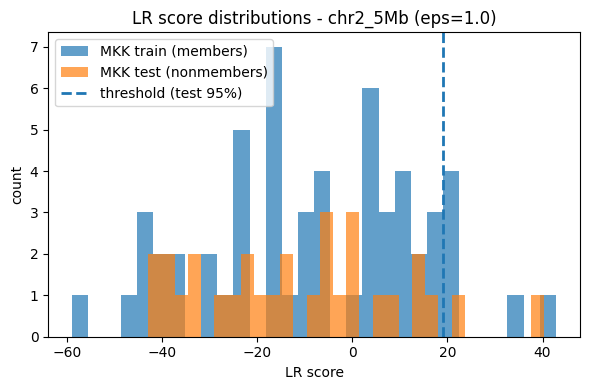

Saved: results/figures/method2/chr2_5Mb.lr_hist_eps_1p0_MKK.png


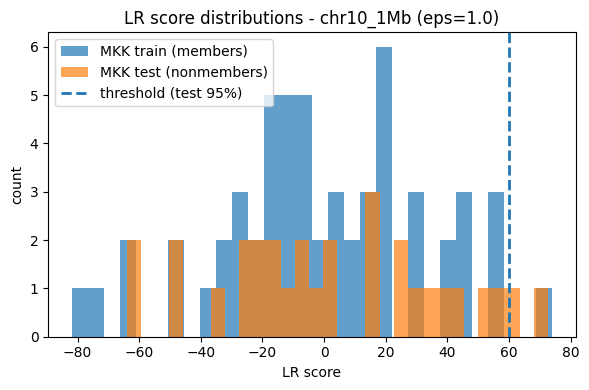

Saved: results/figures/method2/chr10_1Mb.lr_hist_eps_1p0_MKK.png


In [63]:
import glob
from pathlib import Path


# LR histogram for eps=1.0 

EPS_TO_PLOT = 1.0
SEED_TO_PLOT = 0

for region_label, baseline, case_idx, test_idx in [
    ("chr2_5Mb", baseline_chr2, train_idx_chr2, test_idx_chr2),
    ("chr10_1Mb", baseline_chr10, train_idx_chr10, test_idx_chr10),
]:
    eps_dir = DERIVED_DIR / f"eps_{str(EPS_TO_PLOT).replace('.', 'p')}" / f"seed_{SEED_TO_PLOT}"
    out_name = (
        f"chr2_case_maf_noisy_{CASE_POP}_method2.npz"
        if region_label == "chr2_5Mb"
        else f"chr10_case_maf_noisy_{CASE_POP}_method2.npz"
    )
    npz_path = eps_dir / out_name
    if not npz_path.exists():
        pattern = str(eps_dir / f"{region_label.split('_')[0]}_case_maf_noisy_*_method2.npz")
        matches = sorted(glob.glob(pattern))
        if matches:
            npz_path = Path(matches[0])
        else:
            raise FileNotFoundError(f"No method2 NPZ found under {eps_dir}. Re-run main loop.")

    z = np.load(npz_path, allow_pickle=True)
    noisy_maf = z["noisy_maf"]
    p_ctrl_used = z["p_ctrl_used"]
    covered_idx = z["covered_idx"]

    G_case = baseline["G_case"][covered_idx]
    scores_case = lr_scores(G_case, case_idx, p_case=noisy_maf, p_ctrl=p_ctrl_used)
    scores_test = lr_scores(G_case, test_idx, p_case=noisy_maf, p_ctrl=p_ctrl_used)
    thresh = float(np.quantile(scores_test, 0.95))

    plt.figure(figsize=(6, 4))
    plt.hist(scores_case, bins=30, alpha=0.7, label=f"{CASE_POP} train (members)")
    plt.hist(scores_test, bins=30, alpha=0.7, label=f"{CASE_POP} test (nonmembers)")
    plt.axvline(thresh, linestyle="--", linewidth=2, label="threshold (test 95%)")
    plt.xlabel("LR score")
    plt.ylabel("count")
    plt.title(f"LR score distributions - {region_label} (eps=1.0)")
    plt.legend()
    out = FIG_DIR / f"{region_label}.lr_hist_eps_1p0_{CASE_POP}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out.relative_to(PROJECT_ROOT))


In [64]:

# Quick sanity checks


print(summary[["region", "eps", "true_sig_mean", "noisy_sig_mean", "jaccard_mean", "lr_power_case_above_threshold_mean"]])

for region_label in summary["region"].unique():
    true_sig = summary[summary["region"] == region_label]["true_sig_mean"].iloc[0]
    noisy_sig = summary[summary["region"] == region_label]["noisy_sig_mean"].tolist()
    if all(x == 0 for x in noisy_sig):
        print(f"[WARN] {region_label}: noisy_sig is 0 for all eps.")
    print(f"{region_label}: true_sig_mean={true_sig}")


       region    eps  true_sig_mean  noisy_sig_mean  jaccard_mean  \
0   chr10_1Mb   0.03          234.0      143.600000      0.230927   
1   chr10_1Mb   0.10          234.0      140.233333      0.226668   
2   chr10_1Mb   0.30          234.0      130.400000      0.216807   
3   chr10_1Mb   1.00          234.0      102.933333      0.193655   
4   chr10_1Mb   3.00          234.0       74.533333      0.161921   
5   chr10_1Mb  10.00          234.0       59.266667      0.159911   
6    chr2_5Mb   0.03          137.0       56.333333      0.166849   
7    chr2_5Mb   0.10          137.0       53.400000      0.158565   
8    chr2_5Mb   0.30          137.0       45.833333      0.145210   
9    chr2_5Mb   1.00          137.0       30.966667      0.109422   
10   chr2_5Mb   3.00          137.0       26.866667      0.115323   
11   chr2_5Mb  10.00          137.0       34.200000      0.122548   

    lr_power_case_above_threshold_mean  
0                             0.101754  
1                   